 ## Financial Transaction Classifier  ##

In [5]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

Matplotlib is building the font cache; this may take a moment.


In [2]:
df = pd.read_csv("transactions.csv")
df.shape

(314, 6)

In [3]:
df = df.dropna(subset=['clean_description', 'category'])
# df.shape  (313, 6)

In [14]:
def clean_text(text):

    if not isinstance(text, str):
        return ""
    text = text.lower()  # lowercase
    text = re.sub(r'[^a-z0-9\s]', ' ', text)  # remove punctuation & special chars
    text = re.sub(r'\s+', ' ', text)  # collapse multiple spaces
    text = text.strip()
    return text


# Apply cleaning
df['clean_description2'] = df['clean_description'].apply(clean_text)

# print(df[['clean_description2', 'clean_description', 'category']]


In [15]:
df['tokens2'] = df['clean_description2'].str.lower().str.split()

from collections import Counter

all_tokens2 = [token for tokens in df['tokens2'] for token in tokens]
token_counts2 = Counter(all_tokens2)

threshold = 3
common_tokens2 = {token for token, count in token_counts2.items() if count >= threshold}

vocab_dict2 = {token: idx + 1 for idx, token in enumerate(sorted(common_tokens2))}

In [17]:
def text_to_indices(text, vocab_dict):
    tokens = text.lower().split()
    return [vocab_dict.get(token, 0) for token in tokens]  # 0 for unknowns

df['sequence2'] = df['clean_description2'].apply(lambda x: text_to_indices(x, vocab_dict2))


In [20]:
from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 12  # based on your earlier analysis
X_seq2 = pad_sequences(df['sequence2'], maxlen=MAX_LEN, padding='post', truncating='post')


RecursionError: maximum recursion depth exceeded while calling a Python object

In [141]:
def text_to_indices(text, vocab_dict):
    tokens = text.lower().split()  # simple whitespace tokenizer
    indices = [vocab_dict.get(token, 0) for token in tokens]  # 0 if unknown
    return indices

sample_text = "tiong bahru pokeball market"
print(text_to_indices(sample_text, vocab_dict))


[189, 10, 0, 0]


In [142]:
print(vocab_dict.get('tiong'))  # expect 189
print(vocab_dict.get('bahru'))  # expect 10

189
10


In [143]:
def pad_sequences(sequences, max_len, padding_value=0):
    padded = []
    for seq in sequences:
        if len(seq) < max_len:
            seq = seq + [padding_value] * (max_len - len(seq))
        else:
            seq = seq[:max_len]  # truncate if too long
        padded.append(seq)
    return padded

# Example:
sample_seqs = [
    text_to_indices("tiong bahru pokeball market", vocab_dict),
    text_to_indices("apple breadtalk", vocab_dict)
]

max_len = 6
padded_seqs = pad_sequences(sample_seqs, max_len)
print(padded_seqs)


[[189, 10, 0, 0, 0, 0], [7, 21, 0, 0, 0, 0]]


In [144]:
# Build vocabulary from tokens NOT in rare_tokens (i.e., common tokens)
common_tokens = [token for token in token_counts if token not in rare_tokens]

# Create vocab dictionary with indices starting from 1 (0 reserved for unknown tokens)
vocab_dict = {token: idx for idx, token in enumerate(common_tokens, start=1)}

print(f"Vocabulary size (common tokens only): {len(vocab_dict)}")

Vocabulary size (common tokens only): 219


In [145]:
# Example usage
sample_text = "syfe portfolio sg unknownword"
print(text_to_indices(sample_text, vocab_dict))

[0, 0, 67, 0]


In [149]:
df['token_indices'] = df['clean_description'].apply(lambda x: text_to_indices(x, vocab_dict))

def pad_sequence(seq, max_len, pad_value=0):
    if len(seq) > max_len:
        return seq[:max_len]  # truncate
    else:
        return seq + [pad_value] * (max_len - len(seq))  # pad

max_len = 8  # example length
df['padded_indices'] = df['token_indices'].apply(lambda seq: pad_sequence(seq, max_len))


X = np.array(df['padded_indices'].tolist())
print(X.shape)  # should be (num_samples, max_len)


(313, 8)


In [151]:
# Calculate lengths of all token sequences
seq_lengths = df['token_indices'].apply(len)

# Basic stats
print("Min length:", seq_lengths.min())
print("Max length:", seq_lengths.max())
print("Mean length:", seq_lengths.mean())

# Percentiles (e.g., 90th, 95th)
print("90th percentile length:", seq_lengths.quantile(0.9))
print("95th percentile length:", seq_lengths.quantile(0.95))

df['padded_indices'] = df['token_indices'].apply(lambda seq: pad_sequence(seq, max_len))
X = np.array(df['padded_indices'].tolist())
print("Shape of input array:", X.shape)



Min length: 5
Max length: 118
Mean length: 10.718849840255592
90th percentile length: 12.0
95th percentile length: 12.0
Shape of input array: (313, 8)


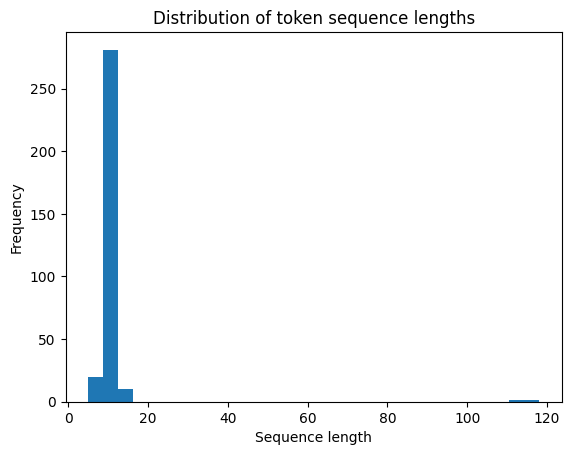

In [152]:

plt.hist(seq_lengths, bins=30)
plt.title('Distribution of token sequence lengths')
plt.xlabel('Sequence length')
plt.ylabel('Frequency')
plt.show()


In [153]:
max_len = 12

def pad_sequence(seq, max_len):
    if len(seq) >= max_len:
        return seq[:max_len]  # truncate if too long
    else:
        return seq + [0] * (max_len - len(seq))  # pad with 0

df['padded_indices'] = df['token_indices'].apply(lambda seq: pad_sequence(seq, max_len))
X = np.array(df['padded_indices'].tolist())

print(f"Shape of input array: {X.shape}")  # (num_samples, max_len)


Shape of input array: (313, 12)


In [155]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())  # should be False on Mac without NVIDIA GPU


2.7.0
False


In [156]:
import torch.nn as nn
import torch.optim as optim

class SimpleTextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.fc = nn.Linear(embed_dim * max_len, num_classes)

    def forward(self, x):
        # x shape: (batch_size, max_len)
        embeds = self.embedding(x)  # (batch_size, max_len, embed_dim)
        embeds = embeds.view(embeds.size(0), -1)  # flatten to (batch_size, max_len*embed_dim)
        out = self.fc(embeds)  # (batch_size, num_classes)
        return out

# Example usage:
vocab_size = len(vocab_dict) + 1  # +1 for padding idx=0
embed_dim = 50
num_classes = 5  # for example

model = SimpleTextClassifier(vocab_size, embed_dim, num_classes)

# Convert X to torch tensor
X_tensor = torch.tensor(X, dtype=torch.long)

# Dummy labels
y = torch.randint(0, num_classes, (len(X_tensor),))

# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Simple training step example
model.train()
optimizer.zero_grad()
outputs = model(X_tensor)
loss = criterion(outputs, y)
loss.backward()
optimizer.step()
print(f"Training loss: {loss.item():.4f}")


In [77]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5],
}

xgb = XGBClassifier(objective='multi:softmax', num_class=15, use_label_encoder=False, eval_metric='mlogloss')

search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=25,  # increase for more thorough search
    scoring='f1_macro',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train, y_train)




Fitting 3 folds for each of 25 candidates, totalling 75 fits


/Users/yvellenah/citicredit-dashboard/venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/Users/yvellenah/citicredit-dashboard/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:01:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/yvellenah/citicredit-dashboard/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:01:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/yvellenah/citicredit-dashboard/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:01:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_enco

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='mlogloss',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_con...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_class=15, ...),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 1, 5],
                                        'learning_rate': [0.01, 0.1, 0.3],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [50, 100, 200],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='f1_macro', verbose=1)

In [79]:
best_model = search.best_estimator_

y_pred = best_model.predict(X_test)
print("Best Params:", search.best_params_)
print("F1 Score (Macro):", f1_score(y_test, y_pred, average='macro'))


from sklearn.metrics import classification_report
import numpy as np

# Get only the classes that are present in y_test
present_labels = np.unique(y_test)
present_class_names = label_encoder.inverse_transform(present_labels)

# Print the report
print(classification_report(y_test, y_pred, target_names=present_class_names))


Best Params: {'subsample': 0.6, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.3, 'gamma': 5, 'colsample_bytree': 0.8}
F1 Score (Macro): 0.2730863499245852
                 precision    recall  f1-score   support

         Beauty       0.00      0.00      0.00         1
           Food       0.65      1.00      0.78        40
            Fun       0.00      0.00      0.00         1
      Groceries       1.00      0.42      0.59        12
         Health       0.00      0.00      0.00         5
Interest Credit       1.00      0.88      0.93         8
     Investment       0.00      0.00      0.00         1
         Salary       0.00      0.00      0.00         6
       Shopping       1.00      0.73      0.85        15
   Subscription       0.00      0.00      0.00         1
       Transfer       0.00      0.00      0.00         1
         Travel       0.09      0.20      0.12         5

       accuracy                           0.67        96
      macro avg       0.31      0.27

/Users/yvellenah/citicredit-dashboard/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/yvellenah/citicredit-dashboard/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/yvellenah/citicredit-dashboard/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif